## Since the algorithm works with even divisions in each multiplex, I am going to keep the donor in, but when looking for the best fit I will remove their features for the comparison (and also need to make sure that donor cannot be in the 4 person batch either o.w would be one subject)

In [1]:
donor_to_drop = "RB1002"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join, exists
import os
%matplotlib inline
from itertools import combinations
from collections import defaultdict 
from src.config import ROOT_DIR, DATA_DIR
from scipy.stats import ttest_ind, chisquare
import tqdm
from copy import deepcopy

Project Directory: /data2/mito_lineage


In [3]:
np.random.seed(42)

In [4]:
outdir = "./output"
out_f = "Chipd10_rmMissingDonor"

In [5]:
if not exists(outdir):
    os.mkdir(outdir)

## Set up parameters for the number of subjects in a batch (day) and number of donors in each multiplex

In [6]:
n_sim=10000
batches=[6,4]
mult=[3,2]

In [7]:
in_f = join(DATA_DIR, "processed", "gilead_chip_profile/CHIPd10", "CHIPd10donor_feature.csv")
donor_meta = pd.read_csv(in_f, index_col=0)
donor_meta

,Sum_VAF,Smoking_Status,Cell_count__viability,Age,Gender,Race
Donor_ID,,,,,,
RB1046,0.546006,0,2870000,53,M,Hispanic
RB1085,0.154719,0,700000,53,F,Hispanic
RB1071,0.141314,0,1600000,54,M,Caucasian
RB1060,0.469024,1,1700000,51,M,Caucasian
RB1065,1.733630,1,1700000,53,F,African_American
RB1002,NaN,1,1300000,50,M,Asian
RB1003,0.014966,0,1090000,64,M,Caucasian
RB1048,0.719311,0,2230000,61,M,Asian
RB1138,0.006915,0,1240000,55,F,African_American


In [8]:
donor_to_drop_index = np.flatnonzero(donor_meta.index==donor_to_drop)[0]
donor_to_drop_index

5

### Sum_VAF is the sum VAF across all CHIP mutations in a donor

## Preprocess and clean df 
make gender and race categorical. 

In [9]:
race_map = {"Hispanic":0, "Caucasian":1, "African_American":2, "Asian":3}
donor_meta["Race"] = donor_meta["Race"].map(race_map)
gend_map ={"M":0,"F":1}
donor_meta["Gender"] = donor_meta["Gender"].map(gend_map)



## A. Plot correlation across features

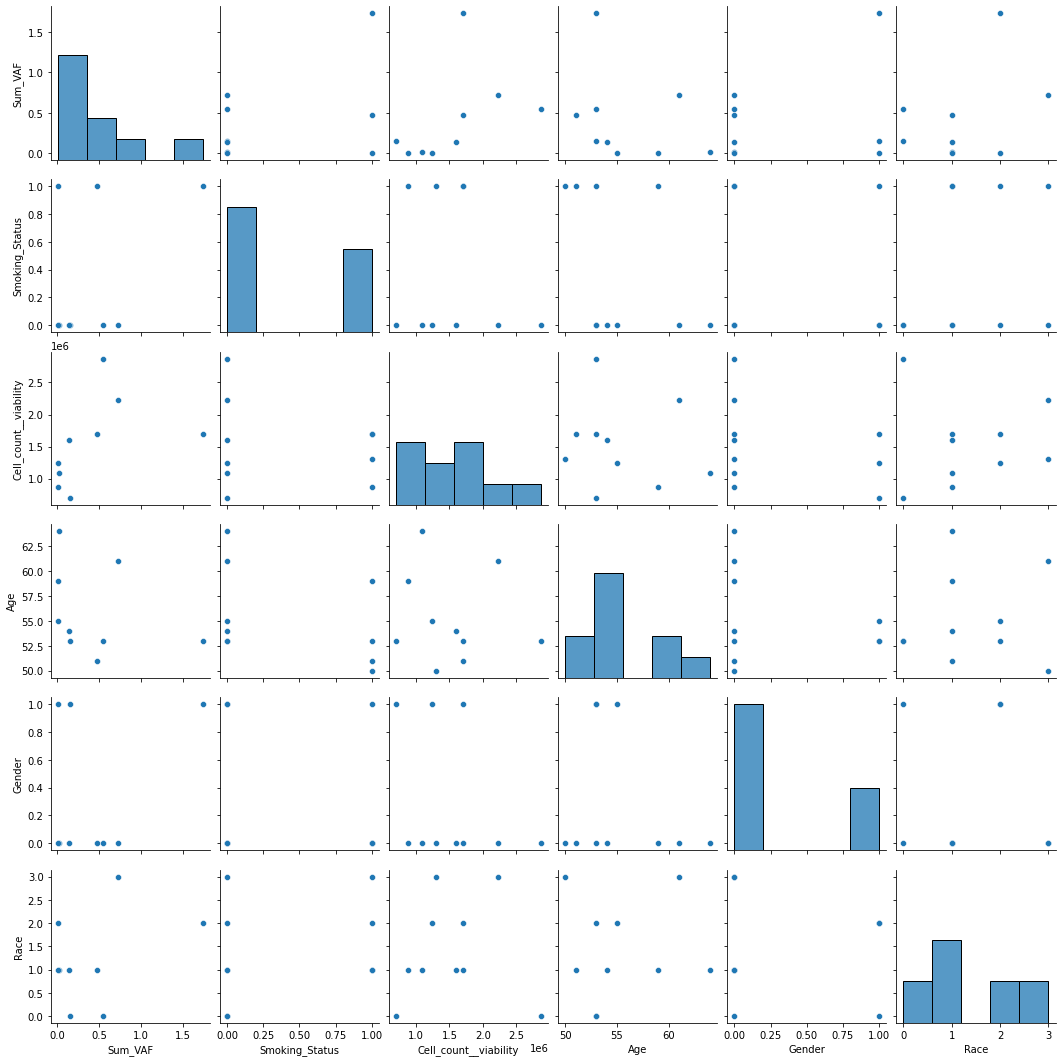

In [10]:
%matplotlib inline
sns.pairplot(donor_meta)

## A. Result: No clear correlation across features, including age-VAF relationship

In [11]:
donor_meta = donor_meta.reset_index()

## B. Sample n_sim times an ordering of donors and store into sim_d

In [12]:
def single_run(sample, batches, mult):
    """ Given a permutation sample & lists of batches and multiplex, will partition donors based on ordering.
    
    """
    #print('sample', sample)
    sim = pd.DataFrame(index=np.arange(len(sample)), columns=["batch","mult"], )
    sim.index.name = "donor"
    for b_ind, b in enumerate(batches):
        curr_b = sample[sum(batches[:b_ind]):sum(batches[:b_ind])+b]
        m_batches = int(np.ceil(b/mult[b_ind]))
        #print("b_ind", b_ind)
        #print('curr_b', curr_b)
        #print('m_batches', m_batches)
        for m_ind in range(m_batches):
            #print("m_ind", m_ind)
            curr_m = curr_b[m_ind*mult[b_ind]:(m_ind*mult[b_ind])+mult[b_ind]]
            #print('curr_m', curr_m)
            sim.loc[curr_m, "batch"] = b_ind
            sim.loc[curr_m, "mult"] = m_ind
            
    return sim

def wrap(n_sim, batches, mult, n_donors=10):
    sim_d={}
    for n in range(n_sim):
        curr = np.random.permutation(n_donors)
        while donor_to_drop_index in curr[6:]: #dont want it in the 2nd, smaller batch
            curr = np.random.permutation(10)
        sim_d[n] = single_run(curr, batches, mult)
    return pd.concat(sim_d).reset_index().rename({"level_0":"sim"}, axis=1)

sim_d = wrap(n_sim, batches=[6,4], mult=[3,2])
sim_d

,sim,donor,batch,mult
0,0,0,0,1
1,0,1,0,0
2,0,2,0,1
3,0,3,1,1
4,0,4,1,0
...,...,...,...,...
99995,9999,5,0,1
99996,9999,6,1,0
99997,9999,7,0,1
99998,9999,8,0,0


## C. For each sampled plate layout, calculate the t-test and/or Chi-square p-value between the two different batches (higher value means samples are more evenly mixed)
(If >2 plates, will need to do Anova instead)

In [13]:
donor_meta

,Donor_ID,Sum_VAF,Smoking_Status,Cell_count__viability,Age,Gender,Race
0,RB1046,0.546006,0,2870000,53,0,0
1,RB1085,0.154719,0,700000,53,1,0
2,RB1071,0.141314,0,1600000,54,0,1
3,RB1060,0.469024,1,1700000,51,0,1
4,RB1065,1.733630,1,1700000,53,1,2
5,RB1002,NaN,1,1300000,50,0,3
6,RB1003,0.014966,0,1090000,64,0,1
7,RB1048,0.719311,0,2230000,61,0,3
8,RB1138,0.006915,0,1240000,55,1,2
9,RB1105,0.005924,1,875000,59,0,1


## ADDED HERE:  Set the donor to drop features to nan

In [14]:
donor_meta.loc[donor_to_drop_index, :] = np.nan

In [15]:
sim_ttest = pd.DataFrame(index=np.arange(n_sim),columns=donor_meta.drop("Donor_ID",axis=1).columns)
for s, df in sim_d.groupby("sim"):
    curr_sol = pd.concat((df.set_index("donor"),donor_meta.reset_index()), axis=1)
    for f in donor_meta.drop("Donor_ID",axis=1).columns: #sim_ttest.append(ttest_ind(df[df["batch"]==0], df[df["batch"]==1]))
        try:
            sim_ttest.loc[s, f]=ttest_ind(curr_sol[curr_sol["batch"]==0][f].fillna(0), curr_sol[curr_sol["batch"]==1][f].fillna(0))[1]
        except TypeError:
            sim_ttest.loc[s, f]=chisquare(curr_sol[curr_sol["batch"]==0][f], curr_sol[curr_sol["batch"]==1][f])[1]

## D. Plot the distributions of the p-value results across each feature 

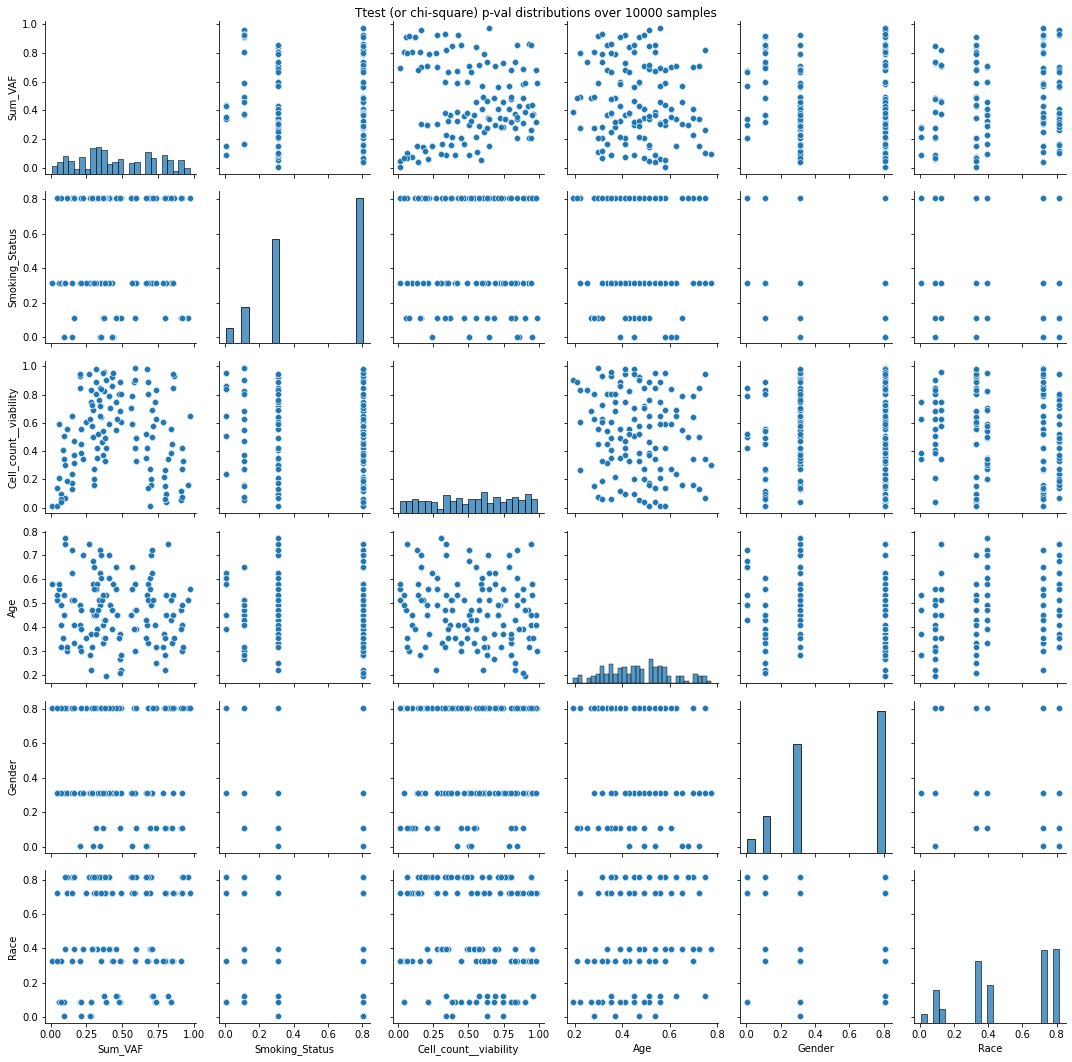

In [16]:
sns.pairplot(sim_ttest)
plt.suptitle("Ttest (or chi-square) p-val distributions over 10000 samples")
plt.tight_layout()

# E. Take best score and plot the features and layout, using variance in multiplex groupings and batch to determine score
Take the mean of the within-multiplex within-batch p-values

In [17]:
sim_ttest_mult = pd.DataFrame(index=np.arange(n_sim),columns=donor_meta.drop("Donor_ID",axis=1).columns)
for s, df in sim_d.groupby("sim"):
    all_mult = defaultdict(list)
    for b, df2 in df.groupby(["batch"]):  
#         print('df2')
#         print(df2)
        df2 = pd.concat((df2.set_index("donor"),donor_meta.reset_index()), axis=1)
        for f in donor_meta.drop("Donor_ID",axis=1).columns: #sim_ttest_mult.append(ttest_ind(df[df["batch"]==0], df[df["batch"]==1]))
            try:
                all_mult[f].append(ttest_ind(df2[df2["mult"]==0][f].fillna(0), df2[df2["mult"]==1][f].fillna(0))[1])
                #sim_ttest_mult.loc[s, f]=ttest_ind(df2[df2["batch"]==0][f].fillna(0), df2[df2["batch"]==1][f].fillna(0))[1]
            except TypeError:
                #sim_ttest_mult.loc[s, f]=chisquare(df2[df2["batch"]==0][f], df2[df2["batch"]==1][f])[1]
                all_mult[f].append(chisquare(df2[df2["mult"]==0][f].fillna(0), df2[df2["mult"]==1][f].fillna(0))[1])
    for f in donor_meta.drop("Donor_ID",axis=1).columns:
        sim_ttest_mult.loc[s, f]= np.mean(np.array(all_mult[f]))
sim_ttest_mult.columns = [x+"_mult" for x in sim_ttest_mult.columns]

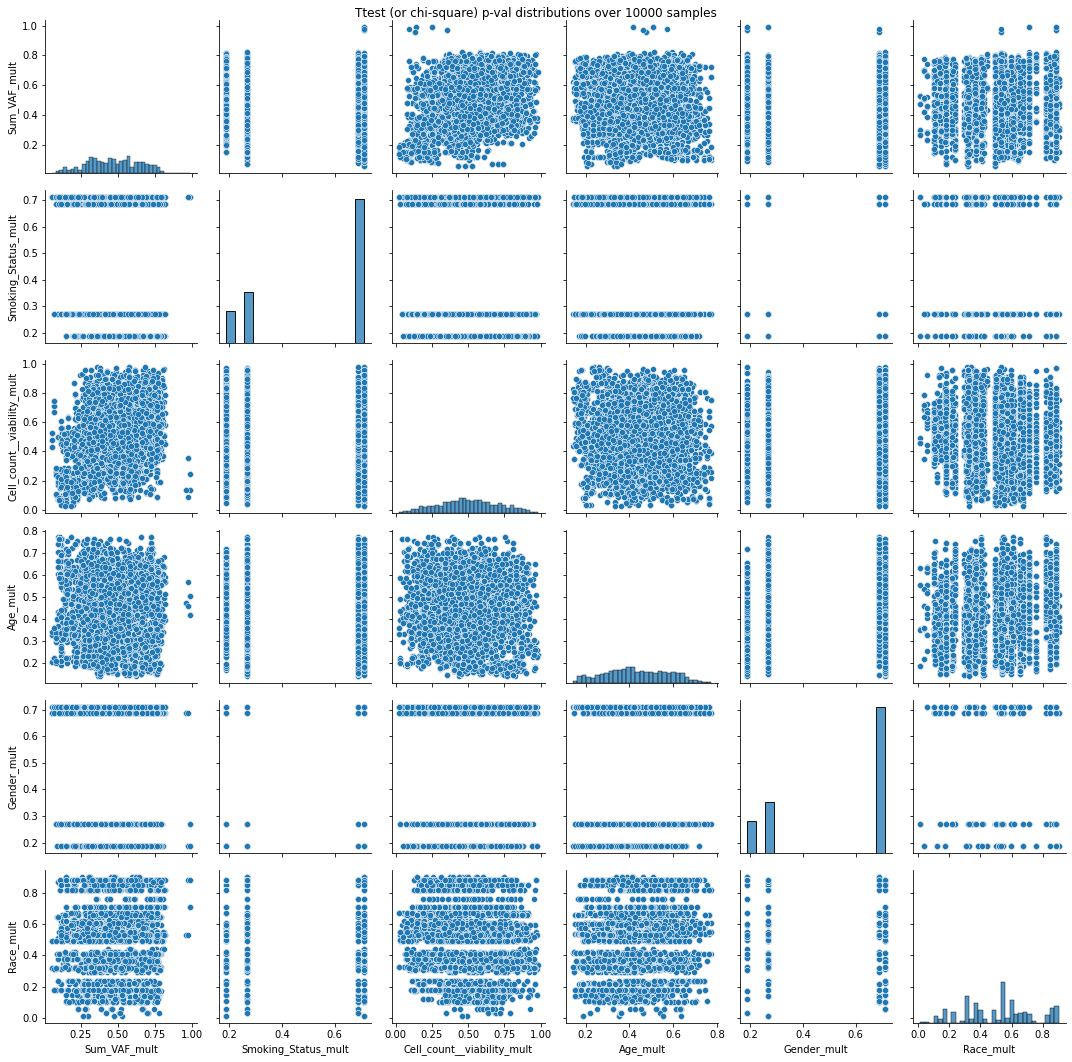

In [18]:
sns.pairplot(sim_ttest_mult)
plt.suptitle("Ttest (or chi-square) p-val distributions over 10000 samples")
plt.tight_layout()

In [19]:
tests_cat = pd.concat((sim_ttest,sim_ttest_mult),axis=1)
tests_cat.head(5)

,Sum_VAF,Smoking_Status,Cell_count__viability,Age,Gender,Race,Sum_VAF_mult,Smoking_Status_mult,Cell_count__viability_mult,Age_mult,Gender_mult,Race_mult
0,0.432603,0.00527611,0.862969,0.390204,0.806661,0.720751,0.317839,NaN,0.444959,0.59329,0.269383,0.500833
1,0.482444,0.806661,0.888261,0.207621,0.111434,0.327123,0.462259,0.269383,0.708357,0.598884,NaN,0.573654
2,0.0564359,0.31216,0.592832,0.581292,0.31216,0.327123,0.472122,0.68695,0.267218,0.544233,0.18695,0.598058
3,0.319564,0.31216,0.805935,0.371125,0.111434,0.812087,0.648951,0.68695,0.44925,0.60157,NaN,NaN
4,0.381839,0.31216,0.490407,0.352519,0.806661,0.812087,0.326813,0.68695,0.554678,0.548361,0.711325,0.530269


In [20]:
# best_sim = tests_cat.sort_values(["Sum_VAF", "Sum_VAF_mult",
#                                   "Cell_count__viability", "Smoking_Status", 
#                                  "Cell_count__viability_mult", "Gender", "Gender_mult", 
#                                  "Age", "Age_mult"], ascending=False).iloc[0].name
# print(best_sim)
# best_df = sim_d.loc[sim_d["sim"]==best_sim]
# best_df

# # Best fit layout

# x = []
# y = []
# txt = []
# f = plt.figure()
# for ind, val in best_df.groupby(["mult", "batch"]):
#     x.append(ind[0])
#     y.append(ind[1])
#     txt.append(",".join(donor_meta.loc[val["donor"], "Donor_ID"].dropna().values))

    
# fig, ax = plt.subplots()
# ax.scatter(x,y)
# for i, t in enumerate(txt):
#     ax.annotate(t, (x[i], y[i]))

# plt.xlabel("Multiplex group")
# plt.ylabel("Batch day group")

# count=0
# n_batch = len(best_df["batch"].unique())
# f, ax = plt.subplots(nrows=len(donor_meta.columns)-1, ncols=n_batch, figsize=(12,12))

# best_in = pd.concat((best_df.set_index("donor"), donor_meta),axis=1)
# for feat in donor_meta.drop("Donor_ID",axis=1).columns:
#     print(feat)
#     for b in range(n_batch):        
#         sns.swarmplot(data=best_in[best_in["batch"]==b], y=feat, x = "mult",
#                      ax=ax[count, b])
#         plt.suptitle("Featues for best fit. Column is different batch (day), sub-column is the multiplex groups")
#     count+=1


# Aggregate scoring with weighting

In [21]:
# best_sim = tests_cat.sort_values(["Sum_VAF", "Sum_VAF_mult",
#                                   "Cell_count__viability", "Smoking_Status", 
#                                  "Cell_count__viability_mult", "Gender", "Gender_mult", 
#                                  "Age", "Age_mult"], ascending=False).iloc[0].name
# print(best_sim)
# best_df = sim_d.loc[sim_d["sim"]==best_sim]
# best_df

# # Best fit layout

# x = []
# y = []
# txt = []
# f = plt.figure()
# for ind, val in best_df.groupby(["mult", "batch"]):
#     x.append(ind[0])
#     y.append(ind[1])
#     txt.append(",".join(donor_meta.loc[val["donor"], "Donor_ID"].dropna().values))

    
# fig, ax = plt.subplots()
# ax.scatter(x,y)
# for i, t in enumerate(txt):
#     ax.annotate(t, (x[i], y[i]))

# plt.xlabel("Multiplex group")
# plt.ylabel("Batch day group")

# count=0
# n_batch = len(best_df["batch"].unique())
# f, ax = plt.subplots(nrows=len(donor_meta.columns)-1, ncols=n_batch, figsize=(12,12))

# best_in = pd.concat((best_df.set_index("donor"), donor_meta),axis=1)
# for feat in donor_meta.drop("Donor_ID",axis=1).columns:
#     print(feat)
#     for b in range(n_batch):        
#         sns.swarmplot(data=best_in[best_in["batch"]==b], y=feat, x = "mult",
#                      ax=ax[count, b])
#         plt.suptitle("Featues for best fit. Column is different batch (day), sub-column is the multiplex groups")
#     count+=1


In [22]:
weights = {"Sum_VAF":2, "Sum_VAF_mult":2, "Cell_count__viability":1.8, "Cell_count__viability_mult":1.8,
           "Smoking_Status":1.5, "Smoking_Status_mult":1.5,
          "Age":1, "Age_mult":1, "Gender":1, "Gender_mult":1}

scores = tests_cat.apply(lambda x: sum([x[w]*weights[w] if (not np.isnan(x[w])) else 0 for w in weights]), axis=1)

tests_cat.head()

# best_df

,Sum_VAF,Smoking_Status,Cell_count__viability,Age,Gender,Race,Sum_VAF_mult,Smoking_Status_mult,Cell_count__viability_mult,Age_mult,Gender_mult,Race_mult
0,0.432603,0.00527611,0.862969,0.390204,0.806661,0.720751,0.317839,NaN,0.444959,0.59329,0.269383,0.500833
1,0.482444,0.806661,0.888261,0.207621,0.111434,0.327123,0.462259,0.269383,0.708357,0.598884,NaN,0.573654
2,0.0564359,0.31216,0.592832,0.581292,0.31216,0.327123,0.472122,0.68695,0.267218,0.544233,0.18695,0.598058
3,0.319564,0.31216,0.805935,0.371125,0.111434,0.812087,0.648951,0.68695,0.44925,0.60157,NaN,NaN
4,0.381839,0.31216,0.490407,0.352519,0.806661,0.812087,0.326813,0.68695,0.554678,0.548361,0.711325,0.530269


7055
Sum_VAF
Smoking_Status
Cell_count__viability
Age
Gender
Race


<Figure size 432x288 with 0 Axes>

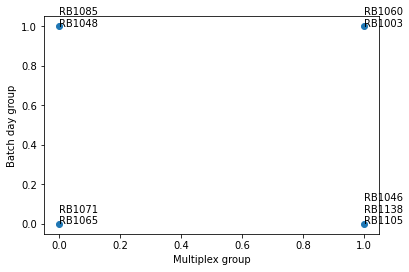

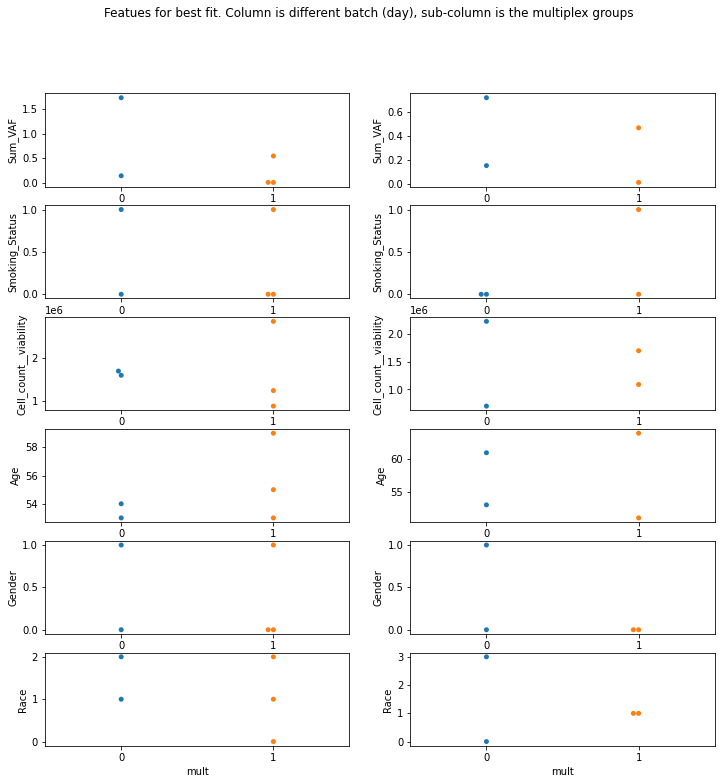

In [25]:
best_sim = scores.sort_values(ascending=False).index[0]
print(best_sim)
best_df = sim_d.loc[sim_d["sim"]==best_sim]
best_df

# Best fit layout

x = []
y = []
txt = []
f = plt.figure()
for ind, val in best_df.groupby(["mult", "batch"]):
    x.append(ind[0])
    y.append(ind[1])
    txt.append("\n".join(donor_meta.loc[val["donor"], "Donor_ID"].dropna().values))

    
fig, ax = plt.subplots()
ax.scatter(x,y)
for i, t in enumerate(txt):
    ax.annotate(t, (x[i], y[i]))

plt.xlabel("Multiplex group")
plt.ylabel("Batch day group")
plt.savefig(join(outdir, f"{out_f}_best_experiment_layout.pdf"), bbox_inches='tight')

count=0
n_batch = len(best_df["batch"].unique())
f, ax = plt.subplots(nrows=len(donor_meta.columns)-1, ncols=n_batch, figsize=(12,12))
best_in = pd.concat((best_df.set_index("donor"), donor_meta),axis=1)
for feat in donor_meta.drop("Donor_ID",axis=1).columns:
    print(feat)
    for b in range(n_batch):        
        sns.swarmplot(data=best_in[best_in["batch"]==b], y=feat, x = "mult",
                     ax=ax[count, b])
        plt.suptitle("Featues for best fit. Column is different batch (day), sub-column is the multiplex groups")
    count+=1

plt.savefig(join(outdir, f"{out_f}_best_experiment_features.pdf"))


## Weight multiplex by half

In [26]:
weights = {"Sum_VAF":2, "Sum_VAF_mult":2/2, "Cell_count__viability":1.8, "Cell_count__viability_mult":1.8/2,
           "Smoking_Status":1.5, "Smoking_Status_mult":1.5/2,
          "Age":1, "Age_mult":1/2, "Gender":1, "Gender_mult":1/2}

scores = tests_cat.apply(lambda x: sum([x[w]*weights[w] if (not np.isnan(x[w])) else 0 for w in weights]), axis=1)

tests_cat.head()

# best_df

,Sum_VAF,Smoking_Status,Cell_count__viability,Age,Gender,Race,Sum_VAF_mult,Smoking_Status_mult,Cell_count__viability_mult,Age_mult,Gender_mult,Race_mult
0,0.432603,0.00527611,0.862969,0.390204,0.806661,0.720751,0.317839,NaN,0.444959,0.59329,0.269383,0.500833
1,0.482444,0.806661,0.888261,0.207621,0.111434,0.327123,0.462259,0.269383,0.708357,0.598884,NaN,0.573654
2,0.0564359,0.31216,0.592832,0.581292,0.31216,0.327123,0.472122,0.68695,0.267218,0.544233,0.18695,0.598058
3,0.319564,0.31216,0.805935,0.371125,0.111434,0.812087,0.648951,0.68695,0.44925,0.60157,NaN,NaN
4,0.381839,0.31216,0.490407,0.352519,0.806661,0.812087,0.326813,0.68695,0.554678,0.548361,0.711325,0.530269


5916
Sum_VAF
Smoking_Status
Cell_count__viability
Age
Gender
Race


<Figure size 432x288 with 0 Axes>

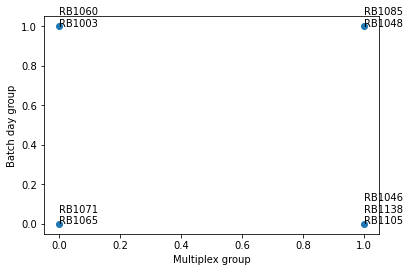

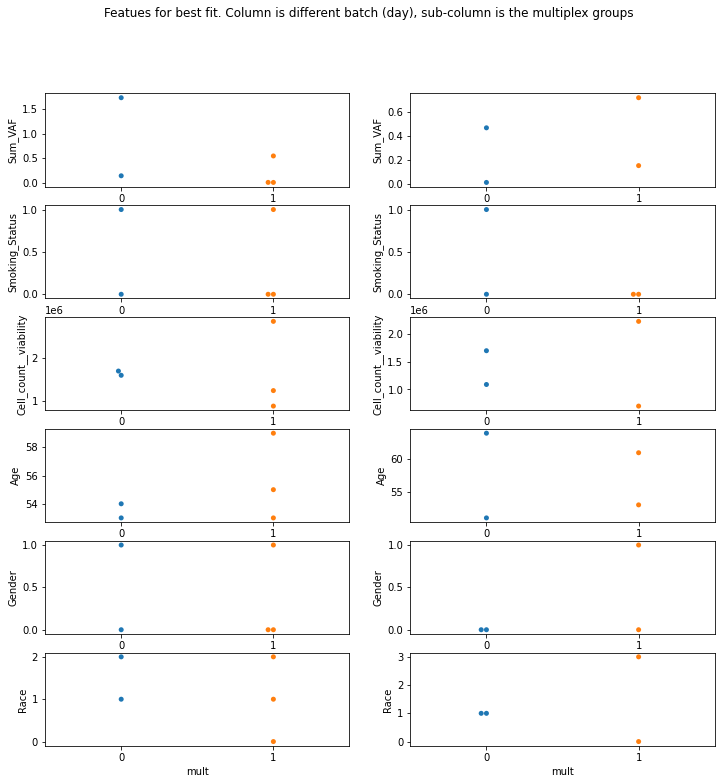

In [27]:
best_sim = scores.sort_values(ascending=False).index[0]
print(best_sim)
best_df = sim_d.loc[sim_d["sim"]==best_sim]
best_df

# Best fit layout

x = []
y = []
txt = []
f = plt.figure()
for ind, val in best_df.groupby(["mult", "batch"]):
    x.append(ind[0])
    y.append(ind[1])
    txt.append("\n".join(donor_meta.loc[val["donor"], "Donor_ID"].dropna().values))

    
fig, ax = plt.subplots()
ax.scatter(x,y)
for i, t in enumerate(txt):
    ax.annotate(t, (x[i], y[i]))

plt.xlabel("Multiplex group")
plt.ylabel("Batch day group")
plt.savefig(join(outdir, f"{out_f}_best_experiment_layout.multLess.pdf"), bbox_inches='tight')

count=0
n_batch = len(best_df["batch"].unique())
f, ax = plt.subplots(nrows=len(donor_meta.columns)-1, ncols=n_batch, figsize=(12,12))
best_in = pd.concat((best_df.set_index("donor"), donor_meta),axis=1)
for feat in donor_meta.drop("Donor_ID",axis=1).columns:
    print(feat)
    for b in range(n_batch):        
        sns.swarmplot(data=best_in[best_in["batch"]==b], y=feat, x = "mult",
                     ax=ax[count, b])
        plt.suptitle("Featues for best fit. Column is different batch (day), sub-column is the multiplex groups")
    count+=1

plt.savefig(join(outdir, f"{out_f}_best_experiment_features.multLess.pdf"))
